In [3]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
from pickle import dump
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('neuron')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
def simpleaxis(axes, every=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [5]:
def getNumBins(X, rule="S"):

    if rule == "FD":
        # Freedman‐Diaconis Rule!
        minMax = max(X) - min(X)
        Qx = sp.stats.iqr(X)
        N_cubrt = np.cbrt(len(X))
        print (minMax, Qx, N_cubrt, minMax/(2.* Qx * N_cubrt))
        return int(np.ceil(minMax/(2.* Qx * N_cubrt)))
    elif rule == "S":
        # Sturges’ Rule!
        return int(np.ceil(1. + np.log2(len(X))))

def calc_MI(X,Y,bins):

    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_XY = np.histogram2d(X,Y, bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    normalized_MI = MI    # In bits, or normalize: /(np.sqrt(H_X*H_Y))
    return normalized_MI

def calc_TI(X,Y,Z,bins):
    ''' Total Information about Z from X and Y, or I(Z; X,Y)'''

    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_Z = np.histogram(Z, bins=bins)[0]

    c_XY = np.histogram2d(X,Y, bins=bins)[0]
    c_XYZ = np.histogramdd((X,Y,Z), bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_Z = shan_entropy(c_Z)

    H_XY = shan_entropy(c_XY)
    H_XYZ = shan_entropy(c_XYZ)

    TI = H_Z + H_XY - H_XYZ
    normalized_TI = TI  # In bits, or normalize: /(np.sqrt(H_X*H_Y))
    return normalized_TI

def gain_inf(X,Y,Z, bins):
    ''' Calculates the gain in information with timing. I(X;Y|Z)'''
    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_Z = np.histogram(Z, bins=bins)[0]

    c_XY = np.histogram2d(X,Y, bins=bins)[0]
    c_XZ = np.histogram2d(X,Z, bins=bins)[0]
    c_YZ = np.histogram2d(Y,Z, bins=bins)[0]
    c_XYZ = np.histogramdd((X,Y,Z), bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_Z = shan_entropy(c_Z)

    H_XY = shan_entropy(c_XY)
    H_XZ = shan_entropy(c_XZ)
    H_YZ = shan_entropy(c_YZ)
    H_XYZ = shan_entropy(c_XYZ)

    GI = H_XZ + H_YZ - H_XYZ - H_Z
    return GI
        
def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))
    return H

In [6]:
def getPars_trialwise(neuron, expType="Control", feature=0, notSqrs = [1]):
    ''' Returns Expected, Observed, Time, Squares for the experiment'''
    exp = neuron.experiment[expType]
    expected = []
    observed = []
    time = []
    sqrArr = []
    for sqr in exp:
        if sqr not in notSqrs:
            for coord in exp[sqr].coordwise:
                for trial in exp[sqr].coordwise[coord].trials:
                    if all([value == 0 for value in trial.flags.values()]) and not np.isnan(exp[sqr].coordwise[coord].expected_feature[feature]):
                        expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                        observed.append(trial.feature[feature])
                        time.append(np.argmax(trial.interestWindow)/20.)
                        sqrArr.append(sqr)
    return expected, observed, time, sqrArr

In [381]:
def getPars(neuron, expType="Control", feature=0, notSqrs = [1]):
    ''' Returns Expected, Observed, Time, Squares for the experiment'''
    exp = neuron.experiment[expType]
    expected = []
    observed = []
    time = []
    sqrArr = []
    avgTrace = []
    for sqr in exp:
        if sqr not in notSqrs:
            for coord in exp[sqr].coordwise:
                if not np.isnan(exp[sqr].coordwise[coord].expected_feature[feature]):
                    obs,t = [], []
                    trace = []
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            obs.append(trial.feature[feature])
                            t.append(np.argmax(trial.interestWindow)/20.)
                            trace.append(trial.interestWindow)
                    if not (all(np.isnan(obs)) or all(np.isnan(t))):
                        observed.append(np.nanmean(obs))
                        expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                        time.append(np.nanmean(t))
                        averagedTrace = np.mean(trace,axis=0)
                        avgTrace.append(averagedTrace)
                        sqrArr.append(sqr)
    return expected, observed, time, sqrArr,avgTrace

In [6]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/normalization_files.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [521]:
feature = 0
scalingFactor = 1e9
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

In [522]:
feature = 0 # Area under the curve
neuron = neurons['170303_c1']
trace = []
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        expected = []
        observed = []
        time = []
        sqrArr = []
        for sqr in exp:
            if sqr > 1:
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                            observed.append(trial.feature[feature])
                            time.append(np.argmax(trial.interestWindow)/20.)
                            trace.append(trial.interestWindow)
                            sqrArr.append(sqr)

In [523]:
observed = np.array(observed)
time = np.array(time)
expected = np.array(expected)
trace = np.array(trace)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  


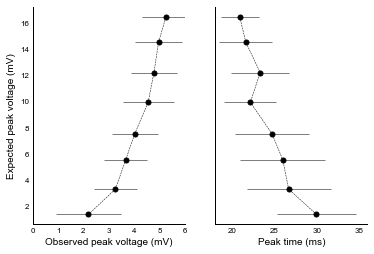

In [526]:
bins = np.linspace(0,20,10)
digitized = np.digitize(expected, bins)
exp_mean = [expected[digitized == i].mean() for i in range(len(bins))]
obs_mean = [observed[digitized == i].mean() for i in range(len(bins))]
obs_std = [observed[digitized == i].std() for i in range(len(bins))]
time_mean = [time[digitized == i].mean() for i in range(len(bins))]
time_std = [time[digitized == i].std() for i in range(len(bins))]

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(obs_mean, exp_mean,'.')
ax[0].errorbar(obs_mean, exp_mean, xerr = obs_std,linestyle='--') #s= 10)
ax[1].plot(time_mean, exp_mean,'.')
ax[1].errorbar(time_mean, exp_mean, xerr = time_std,linestyle='--')# s= 10)

#ax[0].scatter(observed, expected, s= 10)
#ax[1].scatter(time, expected, s= 10)
ax[0].set_xlim(0,6)
ax[1].set_xlim(18,36)
ax[0].set_xlabel('Observed peak voltage (mV)')
ax[1].set_xlabel('Peak time (ms)')
ax[0].set_ylabel('Expected peak voltage (mV)')
simpleaxis(ax)
#dump(fig,file('figures/fig7/7a.pkl','wb'))
plt.show()

## Showing raw traces for timing information (Gabazine vs Control)

### Loading GABAzine containing files

In [90]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files_with_GABAzine.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [91]:
feature = 0
scalingFactor = 1e9
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

In [352]:
feature = 0 # Area under the curve
neuron = neurons['170303_c1']
trace, g_trace, expected, g_expected, g_observed, observed, time, g_time = [], [], [], [], [], [], [], []

g_expected, g_observed, g_time, g_sqrArr, g_trace = getPars(neuron, "GABAzine", notSqrs = notSqrs, feature=feature)
expected, observed, time, sqrArr, trace = getPars(neuron, "Control", notSqrs = notSqrs, feature=feature)

g_time = [np.argmax(averagedTrace)/20. for averagedTrace in g_trace]
g_observed = [np.max(averagedTrace) for averagedTrace in g_trace]

time = [np.argmax(averagedTrace)/20. for averagedTrace in trace]
observed = [np.max(averagedTrace) for averagedTrace in trace]

In [353]:
expected = np.array(expected)
trace = np.array(trace)
g_expected = np.array(g_expected)
g_trace = np.array(g_trace)
observed = np.array(observed)
time = np.array(time)
g_observed = np.array(g_observed)
g_time = np.array(g_time)

In [354]:
numBins=15
bins = np.linspace(0,max(expected),numBins)
digitized = np.digitize(expected, bins)
trace_mean = [trace[digitized == i].mean(axis=0) for i in range(len(bins)) if len(trace[digitized == i])]

bins = np.linspace(0,max(g_expected),numBins)
g_digitized = np.digitize(g_expected, bins)
g_trace_mean = [g_trace[g_digitized == i].mean(axis=0) for i in range(len(bins)) if len(g_trace[g_digitized == i])]

g_trace_time = [g_trace[g_digitized == i].mean(axis=0) for i in range(len(bins)) if len(g_trace[g_digitized == i])]

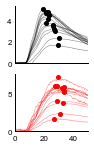

In [355]:
c_mean, g_mean = 0., 0.
alpha=0.5
fig, ax = plt.subplots(2,1,sharex=True)
for i in range(len(trace_mean)):
    ax[0].plot(np.linspace(0,100,len(trace_mean[i])), trace_mean[i], alpha=alpha)
    ax[0].plot(np.argmax(trace_mean[i])/20.,np.max(trace_mean[i]),'.',markersize=8)
    c_mean += (np.argmax(trace_mean[i])/20.)
    
for i in range(len(g_trace_mean)):
    ax[1].plot(np.linspace(0,100,len(g_trace_mean[i])), g_trace_mean[i],'r', alpha=alpha)
    ax[1].plot(np.argmax(g_trace_mean[i])/20.,np.max(g_trace_mean[i]),'r.',markersize=8)
    g_mean += (np.argmax(g_trace_mean[i])/20.)
c_mean/=len(trace_mean)
g_mean/=len(g_trace_mean)

# ax[0].vlines(x=c_mean ,ymin=0., ymax=1.1*np.max(trace_mean),linestyle='--')
# ax[1].vlines(x=g_mean ,ymin=0., ymax=1.1*np.max(g_trace_mean),color='r',linestyle='--')

# ax[1].set_xlabel('Time (ms)')
# ax[1].set_ylabel('Amplitude (mV)')

ax[0].set_xlim(0,50)
ax[0].set_ylim(ymin=0.)
ax[1].set_ylim(ymin=0.)
simpleaxis(ax)
fig.set_figheight(2.3)
fig.set_figwidth(1.3)
dump(fig,file('figures/fig7/7c.pkl','wb'))
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.


1.7567434849 1.7564458013


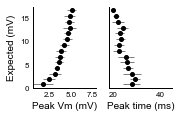

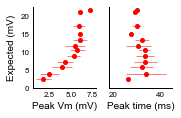

In [356]:
exp_mean = [expected[digitized == i].mean() for i in range(len(bins)) ]
obs_mean = [observed[digitized == i].mean() for i in range(len(bins))]
obs_std = [observed[digitized == i].std() for i in range(len(bins))]
time_mean = [time[digitized == i].mean() for i in range(len(bins))]
time_std = [time[digitized == i].std() for i in range(len(bins))]

g_exp_mean = [g_expected[g_digitized == i].mean() for i in range(len(bins)) ]
g_obs_mean = [g_observed[g_digitized == i].mean() for i in range(len(bins))]
g_obs_std = [g_observed[g_digitized == i].std() for i in range(len(bins))]
g_time_mean = [g_time[g_digitized == i].mean() for i in range(len(bins))]
g_time_std = [g_time[g_digitized == i].std() for i in range(len(bins))]

print(np.nanmin(g_obs_mean), np.nanmin(obs_mean))
omin = 0.3*np.nanmin((np.nanmin(g_obs_mean), np.nanmin(obs_mean)))
omax = 1.1*np.nanmax((np.nanmax(g_obs_mean), np.nanmax(obs_mean)))

tmin = 0.8*np.nanmin((np.nanmin(g_time_mean), np.nanmin(time_mean)))
tmax = 1.2*np.nanmax((np.nanmax(g_time_mean), np.nanmax(time_mean)))

tmin=18.
tmax=45.
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(obs_mean, exp_mean,'.',markersize=8)
ax[0].errorbar(obs_mean, exp_mean, xerr = obs_std, linestyle='') #s= 10)
ax[1].plot(time_mean, exp_mean,'.',markersize=8)
ax[1].errorbar(time_mean, exp_mean, xerr = time_std, linestyle='')# s= 10)
ax[0].set_xlabel('Peak Vm (mV)')
ax[1].set_xlabel('Peak time (ms)')
ax[0].set_ylabel('Expected (mV)')
ax[0].set_xlim(omin, omax)
ax[1].set_xlim(tmin,tmax)
ax[0].set_ylim(ymin=0.)
simpleaxis(ax)
fig.set_figwidth(2.5)
fig.set_figheight(1.5)
dump(fig,file('figures/fig7/7a.pkl','wb'))
plt.show()

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(g_obs_mean, g_exp_mean,'r.',markersize=8)
ax[0].errorbar(g_obs_mean, g_exp_mean, xerr = g_obs_std, color='r', linestyle='') #s= 10)
ax[1].plot(g_time_mean, g_exp_mean,'r.',markersize=8)
ax[1].errorbar(g_time_mean, g_exp_mean, xerr = g_time_std, color='r', linestyle='')# s= 10)


ax[0].set_xlabel('Peak Vm (mV)')
ax[1].set_xlabel('Peak time (ms)')
ax[0].set_ylabel('Expected (mV)')
ax[0].set_xlim(omin, omax)
ax[1].set_xlim(tmin,tmax)
ax[0].set_ylim(ymin=0.)
simpleaxis(ax)
fig.set_figwidth(2.5)
fig.set_figheight(1.5)
dump(fig,file('figures/fig7/7b.pkl','wb'))
plt.show()

In [357]:
bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.)

In [358]:
I_te = calc_MI(time, expected,bins)
I_oe = calc_MI(observed, expected,bins)
I_ote = calc_TI(time, observed, expected ,bins)

In [359]:
I_te, I_oe, I_ote

(0.68864751230257415, 0.79995997073688763, 1.7140363854389999)

## Calculating MI for all cells

In [269]:
I_te, I_oe, I_ote, I_t_gain = [], [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            expected = []
            observed = []
            time = []
            sqrArr = []
            for sqr in exp:
                if sqr > 1:
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                                observed.append(trial.feature[feature])
                                time.append(np.argmax(trial.interestWindow)/20.)
                                sqrArr.append(sqr)
            if len(expected):
                print (len(expected))
                bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.)
                I_te.append(calc_MI(time, expected,bins))
                I_oe.append(calc_MI(observed, expected,bins))
                I_ote.append(calc_TI(time, observed, expected ,bins))
                I_t_gain.append(gain_inf(expected,time, observed, bins))

216
72
361
360
288
288
124
288
351
378
259
334


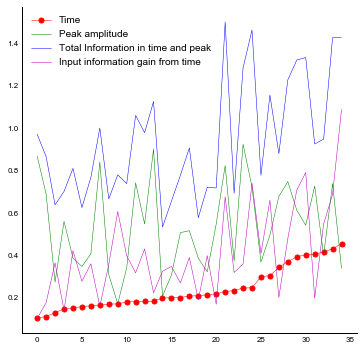

In [47]:
I_te, I_oe, I_ote, I_t_gain = np.array(I_te), np.array(I_oe), np.array(I_ote), np.array(I_t_gain)
fig, ax = plt.subplots()
indices = np.argsort(I_te)
ax.plot(I_te[indices], 'r.-', label="Time")
ax.plot(I_oe[indices], c='g', label="Peak amplitude")
#ax.plot(I_te[indices] + I_oe[indices], 'b--', label="Sum of time and peak amplitude")
ax.plot(I_ote[indices], c='b', label="Total Information in time and peak")
ax.plot(I_t_gain[indices], c='m', label="Input information gain from time")
simpleaxis(ax)
plt.legend()
fig.set_figheight(6)
fig.set_figwidth(6)
plt.savefig('figures/Fig_7_b.png')
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
plt.show()

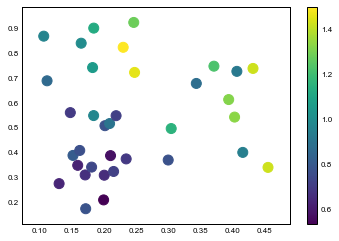

In [49]:
fig, ax = plt.subplots()
cbar = ax.scatter(I_te, I_oe, c= I_ote, cmap=plt.cm.viridis)
# ax.set_xlim(0,0.4)
# ax.set_ylim(0,1)
plt.colorbar(cbar)
plt.show()

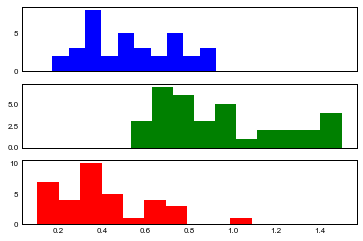

In [50]:
fig, ax = plt.subplots(3,1,sharex=True)
#ax.hist(I_te, color='r', alpha=0.2)
ax[0].hist(I_oe, color='b', alpha=1)
#ax.hist(I_te + I_oe, color='g', alpha=0.2)
ax[1].hist(I_ote, color='g', alpha=1)
ax[2].hist(I_t_gain, color='r', alpha=1)
plt.show()

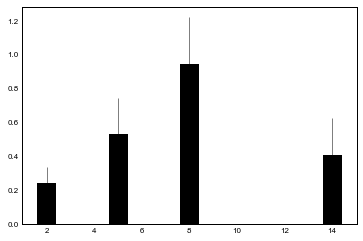

In [51]:
fig1, ax1 = plt.subplots()
ax1.bar(2, np.mean(I_te))
ax1.errorbar(2, np.mean(I_te), yerr= np.std(I_te))

ax1.bar(5, np.mean(I_oe))
ax1.errorbar(5, np.mean(I_oe), yerr= np.std(I_oe))

ax1.bar(8, np.mean(I_ote))
ax1.errorbar(8,np.mean(I_ote), yerr= np.std(I_ote))

#ax1.bar(11, np.mean(I_to))
#ax1.errorbar(11,np.mean(I_to), yerr= np.std(I_to))

ax1.bar(14, np.mean(I_t_gain))
ax1.errorbar(14,np.mean(I_t_gain), yerr= np.std(I_t_gain))
plt.show()

## GABAzine case

161110 c1
5
5


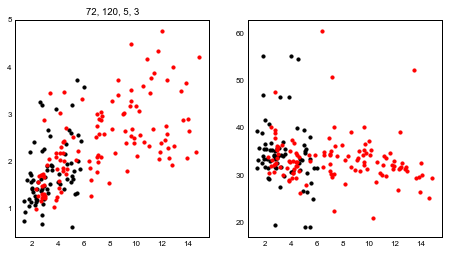

160928 c4
161013 c1
5
5


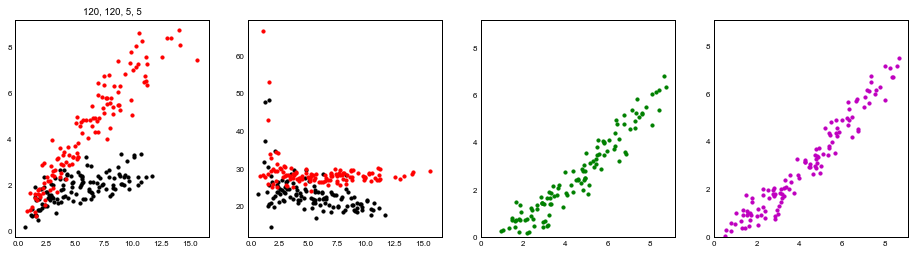

161117 c1
5
5


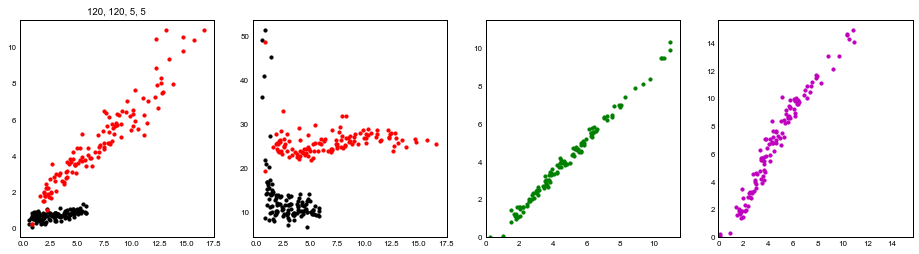

161228 c1
5
5


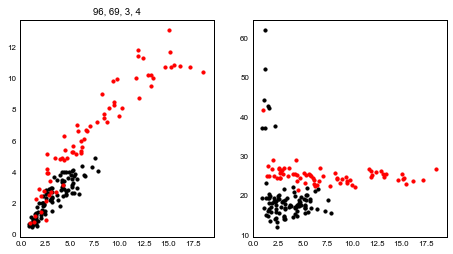

160830 c1
6
5


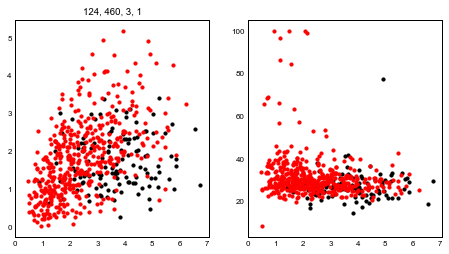

161027 c3
160927 c1
5
5


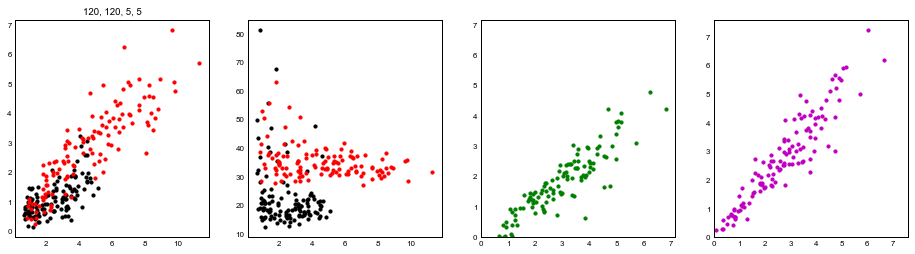

160927 c5
170303 c1
4
5


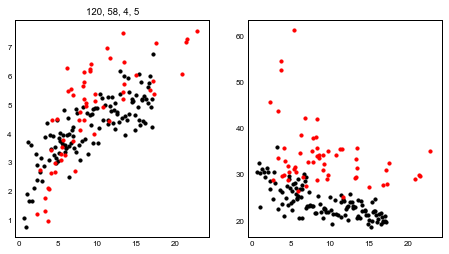

In [692]:
feature = 0 # Area under the curve
minPoints = 40
minIQR = 0
minSqr = 0
notSqrs = [1]
g_I_te, g_I_oe, g_I_ote, g_I_to, g_I_t_gain = [], [], [], [], []
c_I_te, c_I_oe, c_I_ote, c_I_to, c_I_t_gain = [], [], [], [], []
g_sqr, c_sqr = [], []
#neurons.pop('160920_c1')
#neurons.pop('170222_c2')

for index in neurons:
    neuron = neurons[index]
    if "GABAzine" in neuron.experiment:
        print (neuron.date, neuron.index)
        g_expected, g_observed, g_time, g_sqrArr, g_avgTrace = getPars(neuron, "GABAzine", notSqrs = notSqrs, feature=feature)
        c_expected, c_observed, c_time, c_sqrArr, c_avgTrace = getPars(neuron, "Control", notSqrs = notSqrs, feature=feature)
        
        if len(g_expected)>=minPoints and len(c_expected)>=minPoints:
            if ss.iqr(g_expected) >= minIQR and ss.iqr(c_expected) >= minIQR:
                if len(set(c_sqrArr)) >= minSqr and len(set(g_sqrArr)) >= minSqr:

                    bins = int(min([getNumBins(g_expected), getNumBins(g_observed), getNumBins(g_time)])/1.5)
                    g_I_te.append(calc_MI(g_time, g_expected,bins))
                    g_I_oe.append(calc_MI(g_observed, g_expected,bins))
                    g_I_ote.append(calc_TI(g_time, g_observed, g_expected ,bins))
                    g_I_to.append(calc_MI(g_observed, g_time,bins))
                    g_I_t_gain.append(gain_inf(g_expected,g_time, g_observed, bins))
                    g_sqr.append(len(set(g_sqrArr)))
                    print(bins)

                    bins = int(min([getNumBins(c_expected), getNumBins(c_observed), getNumBins(c_time)])/1.5)
                    c_I_te.append(calc_MI(c_time, c_expected,bins))
                    c_I_oe.append(calc_MI(c_observed, c_expected,bins))
                    c_I_ote.append(calc_TI(c_time, c_observed, c_expected ,bins))
                    c_I_to.append(calc_MI(c_observed, c_time,bins))
                    c_I_t_gain.append(gain_inf(c_expected,c_time, c_observed, bins))
                    c_sqr.append(len(set(c_sqrArr)))
                    print(bins)
                    fig, ax = plt.subplots(1,4)
                    dotsize =10
                    g_observed, c_observed = np.array(g_observed), np.array(c_observed)
                    g_avgTrace, c_avgTrace = np.array(g_avgTrace), np.array(c_avgTrace)

                    ax[0].scatter(c_expected, c_observed,c='k',s=dotsize)
                    ax[0].scatter(g_expected, g_observed,c='r',s=dotsize)
                    ax[1].scatter(c_expected, c_time,c='k',s=dotsize)
                    ax[1].scatter(g_expected, g_time,c='r',s=dotsize)
                    if (len(g_observed) == len(c_observed)):
                        
                        ax[2].scatter(g_observed, g_observed-c_observed,c='g',s=dotsize)
                        ymax = max((ax[2].get_xlim()[1],ax[2].get_ylim()[1]))
                        ax[2].set_xlim(0,ymax)
                        ax[2].set_ylim(0,ymax)
                        excit_gabaz, inhib_derived = [], []
                        for i,j in zip(g_avgTrace, c_avgTrace):
                            excit_gabaz.append(np.max(i))
                            inhib_derived.append(np.max(i-j))
                        ax[3].scatter( excit_gabaz, inhib_derived, c='m',s=dotsize)
                        ymax = max((ax[3].get_xlim()[1],ax[3].get_ylim()[1]))
                        ax[3].set_xlim(0,ymax)
                        ax[3].set_ylim(0,ymax)
                        
                    else:
                        fig.delaxes(ax[2])
                        fig.delaxes(ax[3])
                        plt.draw()
                    ax[0].set_title("{}, {}, {}, {}".format(len(c_expected), len(g_expected), g_sqr[-1], c_sqr[-1]))
                    fig.set_figwidth(16)
                    plt.show()
                    plt.close()

In [693]:
g_I_te, g_I_oe, g_I_ote, g_I_to, g_I_t_gain, g_sqr = np.array(g_I_te), np.array(g_I_oe), np.array(g_I_ote), np.array(g_I_to), np.array(g_I_t_gain), np.array(g_sqr)
c_I_te, c_I_oe, c_I_ote, c_I_to, c_I_t_gain, c_sqr = np.array(c_I_te), np.array(c_I_oe), np.array(c_I_ote), np.array(c_I_to), np.array(c_I_t_gain), np.array(c_sqr)

In [694]:
len(g_I_te)

7

In [695]:
g_I_oe

array([ 0.42055499,  1.22536146,  1.28793097,  1.28274815,  0.2729883 ,
        0.7906927 ,  0.56527573])

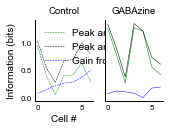

In [696]:
fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
indices = np.argsort(c_I_t_gain)

ax[0].plot(c_I_oe[indices], 'g--', label="Peak amplitude")
ax[0].plot(c_I_ote[indices], 'k--', label="Peak and Time")
# ax[1].plot(g_sqr[indices], 'k--', label="sqrs")
# ax[1].plot(c_I_to[indices], c='b', label="Redundancy in peak and time")
ax[0].plot(c_I_t_gain[indices], 'b--', label="Gain from time")
# ax[1].legend()
simpleaxis(ax)
ax[0].set_title("Control")
ax[0].legend()

# ax[0].plot(g_I_te[indices], c='r', label="Time")
ax[1].plot(g_I_oe[indices], c='g', label="Peak amplitude")
ax[1].plot(g_I_ote[indices], c='k', label="Peak and Time")
# ax[0].plot(g_sqr[indices], c='k', label="sqrs")
# ax[0].plot(g_I_to[indices], c='b', label="Redundancy in peak and time")
ax[1].plot(g_I_t_gain[indices], c='b', label="Gain from time")
# ax[0].legend()
# simpleaxis(ax)
# plt.show()
ax[1].set_title("GABAzine")
# fig, ax = plt.subplots()
# ax[1].plot(c_I_te[indices], 'r--', label="Time")


ax[0].set_xlabel("Cell #")
ax[0].set_ylabel("Information (bits)")

fig.set_figheight(1.5)
fig.set_figwidth(2.3)

dump(fig,file('figures/fig7/7d.pkl','wb'))
plt.show()

### Redundancy between E and T

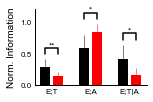

In [720]:
fig1, ax1 = plt.subplots()

ax1.bar(2, np.mean(c_I_te/c_I_ote))
ax1.errorbar(2, np.mean(c_I_te/c_I_ote), yerr= np.std(c_I_te/c_I_ote))
ax1.bar(3, np.mean(g_I_te/g_I_ote), color='r')
ax1.errorbar(3, np.mean(g_I_te/g_I_ote), yerr= np.std(g_I_te/g_I_ote), color='r')
### Significance bars

y, h, col = np.max([np.max(np.mean(g_I_te/g_I_ote)),np.max(np.mean(c_I_te/c_I_ote))])+ 0.2 ,0.1, 'k'
plt.plot([2,2, 3, 3], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((2+3)*.5, y+h, "**", ha='center', va='bottom', color=col)


ax1.bar(5, np.mean(c_I_oe/c_I_ote))
ax1.errorbar(5, np.mean(c_I_oe/c_I_ote), yerr= np.std(c_I_oe/c_I_ote))

ax1.bar(6, np.mean(g_I_oe/g_I_ote), color='r')
ax1.errorbar(6, np.mean(g_I_oe/g_I_ote), yerr= np.std(g_I_oe/g_I_ote), color='r')

y, h, col = np.max([np.max(np.mean(g_I_oe/g_I_ote)),np.max(np.mean(c_I_oe/c_I_ote))])+ 0.2 ,0.1, 'k'
plt.plot([5,5, 6, 6], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((5+6)*.5, y+h, "*", ha='center', va='bottom', color=col)

# ax1.bar(11, np.mean(g_I_ote))
# ax1.errorbar(11,np.mean(g_I_ote), yerr= np.std(g_I_ote))

# ax1.bar(12, np.mean(c_I_ote))
# ax1.errorbar(12,np.mean(c_I_ote), yerr= np.std(c_I_ote))

#ax1.bar(12, np.mean(c_I_to))
#ax1.errorbar(12,np.mean(c_I_to), yerr= np.std(c_I_to))

#ax1.bar(11, np.mean(g_I_to))
#ax1.errorbar(11,np.mean(g_I_to), yerr= np.std(g_I_to))

ax1.bar(8, np.mean(c_I_t_gain/c_I_ote))
ax1.errorbar(8,np.mean(c_I_t_gain/c_I_ote), yerr= np.std(c_I_t_gain/c_I_ote))

ax1.bar(9, np.mean(g_I_t_gain/g_I_ote), color='r')
ax1.errorbar(9,np.mean(g_I_t_gain/g_I_ote), yerr= np.std(g_I_t_gain/g_I_ote), color='r')

y, h, col = np.max([np.max(np.mean(g_I_t_gain/g_I_ote)),np.max(np.mean(c_I_t_gain/c_I_ote))])+ 0.3 ,0.1, 'k'
plt.plot([8,8, 9, 9], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((8+9)*.5, y+h, "*", ha='center', va='bottom', color=col)

ax1.set_ylim(0,1.2)

indices = [2.5, 5.5, 8.5]
ax1.set_xticks(indices)
ax1.set_xticklabels(('E;T', 'E;A', 'E;T|A'))

ax1.set_ylabel("Norm. Information")

simpleaxis(ax1)
fig1.set_figwidth(2)
fig1.set_figheight(1.4)
dump(fig1,file('figures/fig7/7e.pkl','wb'))
plt.show()

In [721]:
print(ss.ranksums(g_I_te/g_I_ote, c_I_te/c_I_ote))
print(ss.ranksums(g_I_oe/g_I_ote, c_I_oe/c_I_ote))
print(ss.ranksums(g_I_t_gain/g_I_ote, c_I_t_gain/c_I_ote))
print(ss.ranksums(g_I_ote, c_I_ote))

RanksumsResult(statistic=-2.6193939164997535, pvalue=0.0088086165193740507)
RanksumsResult(statistic=2.3638432904997777, pvalue=0.018086461315687384)
RanksumsResult(statistic=-2.3638432904997777, pvalue=0.018086461315687384)
RanksumsResult(statistic=1.0860901604998978, pvalue=0.27743910513984715)


In [722]:
print(ss.ttest_rel(g_I_te/g_I_ote, c_I_te/c_I_ote))
print(ss.ttest_rel(g_I_oe/g_I_ote, c_I_oe/c_I_ote))
print(ss.ttest_rel(g_I_t_gain/g_I_ote, c_I_t_gain/c_I_ote))
print(ss.ttest_rel(g_I_ote, c_I_ote))

Ttest_relResult(statistic=-3.497050873712412, pvalue=0.012872426392743568)
Ttest_relResult(statistic=4.0255465169664557, pvalue=0.0069151456777986151)
Ttest_relResult(statistic=-4.0255465169665277, pvalue=0.0069151456777980548)
Ttest_relResult(statistic=1.6414542029401493, pvalue=0.1518116909740152)


In [723]:
zip(np.array(g_I_te) + np.array(g_I_oe) - np.array(g_I_ote), np.array(c_I_te) + np.array(c_I_oe) - np.array(c_I_ote))

[(-0.11881319401207779, -0.33465110622997063),
 (0.10013301820398723, -0.025218382823546381),
 (0.12622897688445178, 0.0037891880712930259),
 (0.092973927750417573, 0.10215627388904025),
 (-0.057303856196422753, -0.15808398626016817),
 (0.018082024925965889, -0.057929011268635922),
 (0.047223745003582174, 0.14109617281313636)]

In [724]:
zip(np.array(g_I_te)/g_I_ote , np.array(c_I_te)/c_I_ote )

[(0.12350625796873287, 0.21671788907543948),
 (0.081717127297897499, 0.37168334155973531),
 (0.1505488088391323, 0.39902379407057487),
 (0.12334142394193133, 0.17291758161659992),
 (0.12856679384363959, 0.22089773763189563),
 (0.15318008193725779, 0.16193963192814473),
 (0.30089803260359937, 0.50732863258140137)]

In [725]:
zip(np.array(g_I_oe)/g_I_ote , np.array(c_I_oe)/c_I_ote )

[(0.68341779858244134, 0.36296558787088795),
 (1.0000000000000007, 0.59236026071177417),
 (0.94175141601605961, 0.60657184571906675),
 (0.94516433932961574, 0.92536340816521268),
 (0.72024438093449683, 0.21170770203640368),
 (0.86663872126977848, 0.73133477211709252),
 (0.76282957349851677, 0.63188477919672814)]

In [726]:
zip(g_I_ote , c_I_ote )

[(0.61537026254940397, 0.79618831969457737),
 (1.2253614574451968, 0.70136010325540177),
 (1.3675912174915075, 0.67716797609228063),
 (1.3571694308679141, 1.0394306581143611),
 (0.3790217703744414, 0.27861385588143772),
 (0.91236714634444915, 0.54278461272954637),
 (0.74102493239604117, 1.0135242790975303)]

In [727]:
zip(np.array(g_I_t_gain)/g_I_ote , np.array(c_I_t_gain)/c_I_ote )

[(0.31658220141756011, 0.63703441212911316),
 (3.624148671820977e-16, 0.40763973928822894),
 (0.058248583983940408, 0.39342815428093331),
 (0.054835660670383618, 0.074636591834787325),
 (0.27975561906551261, 0.78829229796359634),
 (0.13336127873022155, 0.26866522788291397),
 (0.23717042650148473, 0.36811522080327475)]

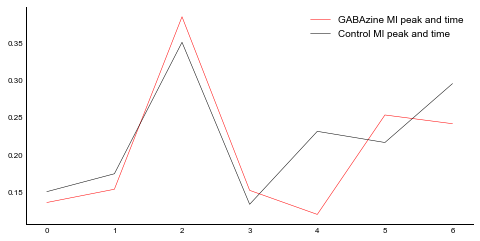

In [728]:
fig, ax = plt.subplots()
indices = np.argsort(c_I_t_gain/c_I_ote)
ax.plot(g_I_to[indices]/g_I_ote[indices], 'r', label="GABAzine MI peak and time")
ax.plot(c_I_to[indices]/c_I_ote[indices], 'k', label="Control MI peak and time")
simpleaxis(ax)
ax.legend()
fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

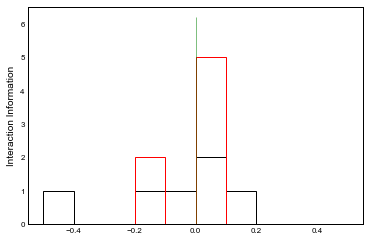

In [729]:
bins = np.linspace(-0.5,0.5,11)
plt.hist((c_I_te - c_I_t_gain)/c_I_ote, bins=bins, color='k',histtype='step')
plt.hist((g_I_te - g_I_t_gain)/g_I_ote, bins=bins, color='r',histtype='step')
plt.vlines(x=0,ymin=0,ymax=6.2,color='g')
plt.ylabel("Interaction Information")
plt.show()

In [730]:
np.mean(g_I_te/g_I_ote), np.mean(g_I_t_gain/g_I_ote)

(0.15167978949031299, 0.15427911005272904)

In [731]:
np.mean(c_I_te/c_I_ote), np.mean(c_I_t_gain/c_I_ote)

(0.29292980120911311, 0.41968737774040676)

In [732]:
c_sqr, g_sqr

(array([3, 5, 5, 4, 1, 5, 5]), array([5, 5, 5, 3, 3, 5, 4]))

# Squares prediction Information Theory

In [ ]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_with_CS.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [ ]:
feature = 0
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

In [ ]:
I_tsq, I_osq, I_otsq = [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            expected = []
            observed = []
            time = []
            sqrArr = []
            for sqr in exp:
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            observed.append(trial.feature[feature])
                            time.append(np.argmax(trial.interestWindow)/20.)
                            sqrArr.append(sqr)
            if len(sqrArr):
                #bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.5)
                bins = max(set(sqrArr)) - 1
                I_tsq.append(calc_MI(time, sqrArr, bins))
                I_osq.append(calc_MI(observed, sqrArr,bins))
                I_otsq.append(calc_TI(time, observed, sqrArr ,bins))

In [ ]:
I_tsq, I_osq, I_otsq = np.array(I_tsq), np.array(I_osq), np.array(I_otsq)
fig, ax = plt.subplots()
indices = np.argsort(I_otsq)
ax.plot(I_tsq[indices], 'r.-', label="Time")
ax.plot(I_osq[indices], 'g.-', label="Peak amplitude")
# ax.plot(I_tsq[indices] + I_osq[indices], 'm.--', label="Sum of time and peak amplitude")
ax.plot(I_otsq[indices], 'b.-', label="Total Information in time and peak")
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--')
simpleaxis(ax)
plt.legend()
fig.set_figheight(8)
fig.set_figwidth(8)
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
plt.show()

## GABAzine case

In [ ]:
I_tsq, I_osq, I_otsq, n_indices, I_t_gain = [], [], [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    if "GABAzine" in neuron.experiment:
        for expType, exp in neuron:
            ## Control case
            if(expType == "Control"):
                expected = []
                observed = []
                time = []
                sqrArr = []
                for sqr in exp:
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                observed.append(trial.feature[feature])
                                time.append(np.argmax(trial.interestWindow)/20.)
                                sqrArr.append(sqr)
                if len(sqrArr):
                    #bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.5)
                    n_indices.append("{}_{}".format(neuron.date, neuron.index))
                    bins = max(set(sqrArr)) - 1
                    I_tsq.append(calc_MI(time, sqrArr, bins))
                    I_osq.append(calc_MI(observed, sqrArr,bins))
                    I_otsq.append(calc_TI(time, observed, sqrArr ,bins))
                    I_t_gain.append(gain_inf(sqrArr,time, observed,bins))

In [ ]:
#fig, ax = plt.subplots(2,1,sharex=True)
fig, ax = plt.subplots()
I_tsq, I_osq, I_otsq, I_t_gain = np.array(I_tsq), np.array(I_osq), np.array(I_otsq), np.array(I_t_gain)
indices = np.argsort(I_tsq)
ax.plot(I_tsq[indices], 'rv-', label= "Control " + "Time")
ax.plot(I_osq[indices], 'gv-', label="Control " + "Peak amplitude")
# ax.plot(I_tsq[indices] + I_osq[indices], 'm.--', label="Sum of time and peak amplitude")
ax.plot(I_otsq[indices], 'bv-', label="Control " + "Peak and time")
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--')
ax.legend()
ax.set_ylim(0,1.2)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.bar(2, np.mean(I_tsq))
ax1.errorbar(2, np.mean(I_tsq), yerr= np.std(I_tsq))

ax1.bar(5, np.mean(I_osq))
ax1.errorbar(5, np.mean(I_osq), yerr= np.std(I_osq))

ax1.bar(8, np.mean(I_otsq))
ax1.errorbar(8,np.mean(I_otsq), yerr= np.std(I_otsq))

ax1.bar(11, np.mean(I_t_gain))
ax1.errorbar(11,np.mean(I_t_gain), yerr= np.std(I_t_gain))

I_t_gain_control = I_t_gain
I_osq_control = I_osq
I_otsq_control = I_otsq

In [ ]:
I_tsq, I_osq, I_otsq, n_indices, I_t_gain = [], [], [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    for expType, exp in neuron:
        ## Control case
        if(expType == "GABAzine"):
            expected = []
            observed = []
            time = []
            sqrArr = []
            for sqr in exp:
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            observed.append(trial.feature[feature])
                            time.append(np.argmax(trial.interestWindow)/20.)
                            sqrArr.append(sqr)
            if len(sqrArr):
                #bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.5)
                n_indices.append("{}_{}".format(neuron.date, neuron.index))
                bins = max(set(sqrArr)) - 1
                I_tsq.append(calc_MI(time, sqrArr, bins))
                I_osq.append(calc_MI(observed, sqrArr,bins))
                I_otsq.append(calc_TI(time, observed, sqrArr ,bins))
                I_t_gain.append(gain_inf(sqrArr,time, observed,bins))

In [ ]:
I_tsq, I_osq, I_otsq, I_t_gain = np.array(I_tsq), np.array(I_osq), np.array(I_otsq), np.array(I_t_gain)
ax.plot(I_tsq[indices], 'ro--', label="GABAzine " + "Time")
ax.plot(I_osq[indices], 'go--', label="GABAzine " + "Peak amplitude")
# ax.plot(I_tsq[indices] + I_osq[indices], 'm.--', label="Sum of time and peak amplitude")
ax.plot(I_otsq[indices], 'bo--', label="GABAzine " + "Peak and time")
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--')
ax.legend()
# ax.set_xlim(0,1)
ax.set_ylim(0,1.2)
fig.set_figheight(8)
fig.set_figwidth(8)

In [ ]:
ax1.bar(3, np.mean(I_tsq))
ax1.errorbar(3, np.mean(I_tsq), yerr= np.std(I_tsq))

ax1.bar(6, np.mean(I_osq))
ax1.errorbar(6, np.mean(I_osq), yerr= np.std(I_osq))

ax1.bar(9, np.mean(I_otsq))
ax1.errorbar(9,np.mean(I_otsq), yerr= np.std(I_otsq))

ax1.bar(12, np.mean(I_t_gain))
ax1.errorbar(12,np.mean(I_t_gain), yerr= np.std(I_t_gain))
plt.show()

I_t_gain_gaba = I_t_gain
I_osq_gaba = I_osq
I_otsq_gaba = I_otsq

In [ ]:
print(ss.ranksums(I_t_gain_gaba, I_t_gain_control))
print(ss.ranksums(I_osq_gaba, I_osq_control))
print(ss.ranksums(I_otsq_gaba, I_otsq_control))